<a href="https://colab.research.google.com/github/mhtabkrklt/ML_Tasks/blob/main/Claustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from sklearn.base import clone
import kagglehub
import os


In [17]:
path = kagglehub.dataset_download("zubairmustafa/shopping-mall-customer-segmentation-data")

print("Path to dataset files:", path)
files = os.listdir(path)
print("Файлы в папке:", files)
csv_file = [f for f in files if f.endswith('.csv')][0]

full_file_path = os.path.join(path, csv_file)

df = pd.read_csv(full_file_path)

df.head()

Using Colab cache for faster access to the 'shopping-mall-customer-segmentation-data' dataset.
Path to dataset files: /kaggle/input/shopping-mall-customer-segmentation-data
Файлы в папке: ['Shopping Mall Customer Segmentation Data .csv']


,Customer ID,Age,Gender,Annual Income,Spending Score
0,d410ea53-6661-42a9-ad3a-f554b05fd2a7,30,Male,151479,89
1,1770b26f-493f-46b6-837f-4237fb5a314e,58,Female,185088,95
2,e81aa8eb-1767-4b77-87ce-1620dc732c5e,62,Female,70912,76
3,9795712a-ad19-47bf-8886-4f997d6046e3,23,Male,55460,57
4,64139426-2226-4cd6-bf09-91bce4b4db5e,24,Male,153752,76


- CustomerID: ID клиента
- Gender: Пол
- Age: Возраст
- Annual Income (k$): Годовой доход
- Spending Score (1-100): Рейтинг расходов(1 мало, 100 много)

Цель: Сегментация клиентов на основе их профилей для содействия маркетингу и анализа характеристик.

In [18]:
df.isnull().sum()

,0
Customer ID,0
Age,0
Gender,0
Annual Income,0
Spending Score,0


In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15079 entries, 0 to 15078
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Customer ID     15079 non-null  object
 1   Age             15079 non-null  int64 
 2   Gender          15079 non-null  object
 3   Annual Income   15079 non-null  int64 
 4   Spending Score  15079 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 589.2+ KB


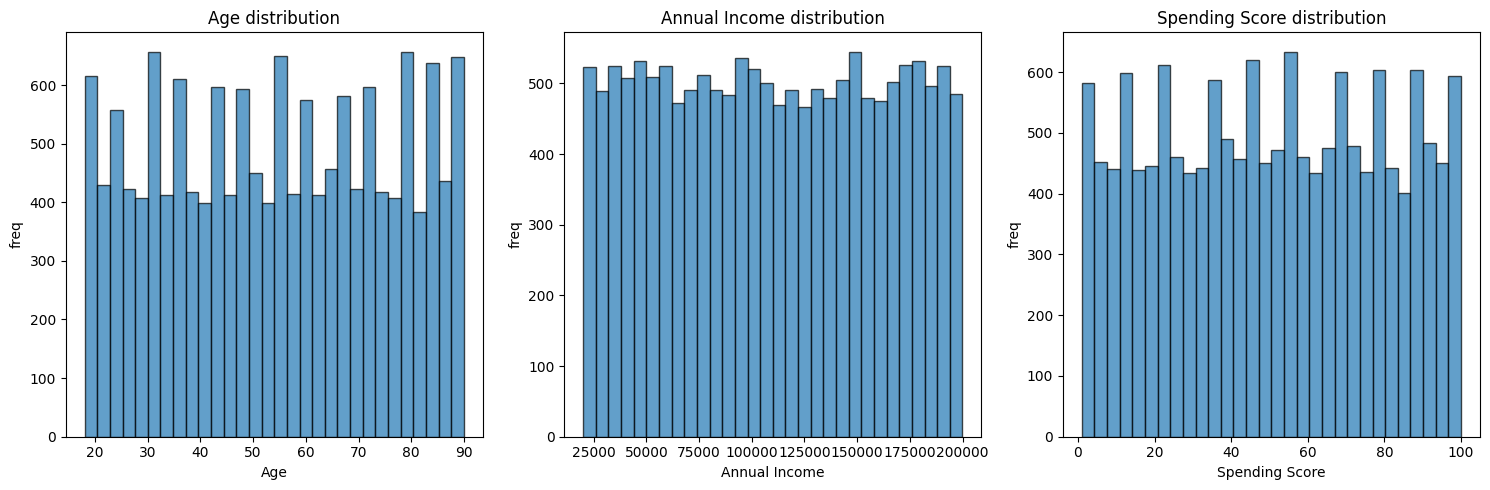

Gender
Male      7595
Female    7484
Name: count, dtype: int64
Gender
Male      0.503681
Female    0.496319
Name: proportion, dtype: float64


In [21]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
num_cols = ['Age','Annual Income','Spending Score']

for i, col in enumerate(num_cols):
    axes[i].hist(df[col], bins=30, alpha=0.7, edgecolor='black')
    axes[i].set_title(f'{col} distribution')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('freq')

plt.tight_layout()
plt.show()
print(df['Gender'].value_counts())
print(df['Gender'].value_counts(normalize=True))

In [22]:
features= ['Annual Income', 'Spending Score']
X = df[features]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

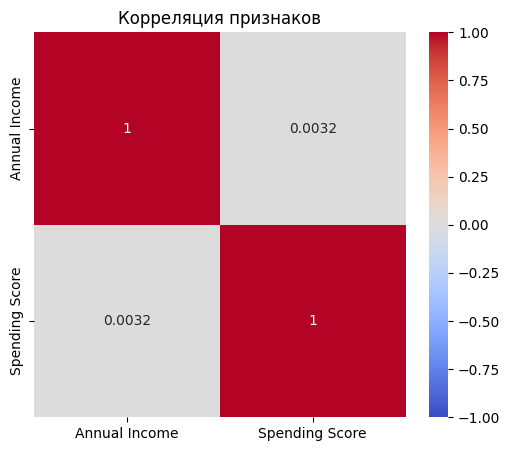

In [24]:
X_df = pd.DataFrame(X_scaled, columns=features)

plt.figure(figsize=(6, 5))
sns.heatmap(X_df.corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Корреляция признаков")
plt.show()

Подбор оптимального k...


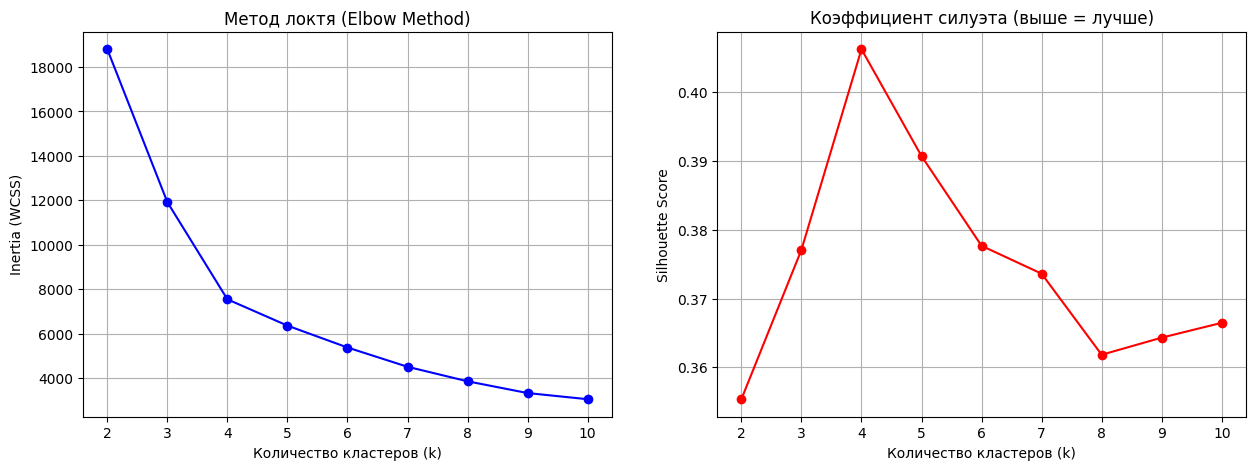

In [10]:
inertia = []
silhouette_scores = []
K_range = range(2, 11)

print("Подбор оптимального k...")

for k in K_range:
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
    kmeans.fit(X_scaled)

    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, kmeans.labels_))

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# 1. Метод локтя (Elbow Method)
ax[0].plot(K_range, inertia, 'bo-')
ax[0].set_title('Метод локтя (Elbow Method)')
ax[0].set_xlabel('Количество кластеров (k)')
ax[0].set_ylabel('Inertia (WCSS)')
ax[0].grid(True)

# 2. Метод силуэта (Silhouette Score)
ax[1].plot(K_range, silhouette_scores, 'ro-')
ax[1].set_title('Коэффициент силуэта (выше = лучше)')
ax[1].set_xlabel('Количество кластеров (k)')
ax[1].set_ylabel('Silhouette Score')
ax[1].grid(True)

plt.show()

Был проведен анализ для определения оптимального числа кластеров (k) с использованием двух методов:

Метод локтя (Elbow Method): График инерции показывает явный изгиб ("локоть") в точке k=5, после чего снижение внутрикластерной ошибки замедляется.

Коэффициент силуэта (Silhouette Score): Максимальное значение метрики достигается при k=5, что говорит о наилучшей разделяемости и плотности кластеров.

Вывод: На основе обоих методов принято решение использовать 5 кластеров для финальной модели.

KMeans

In [11]:
kmeans = KMeans(n_clusters=5, n_init=10, random_state=42)
kmeans.fit(X_scaled)
clusters = kmeans.labels_
silhouette_avg = silhouette_score(X_scaled, clusters)
print(f"silhouette_avg: {silhouette_avg:.4f}")

silhouette_avg: 0.3907


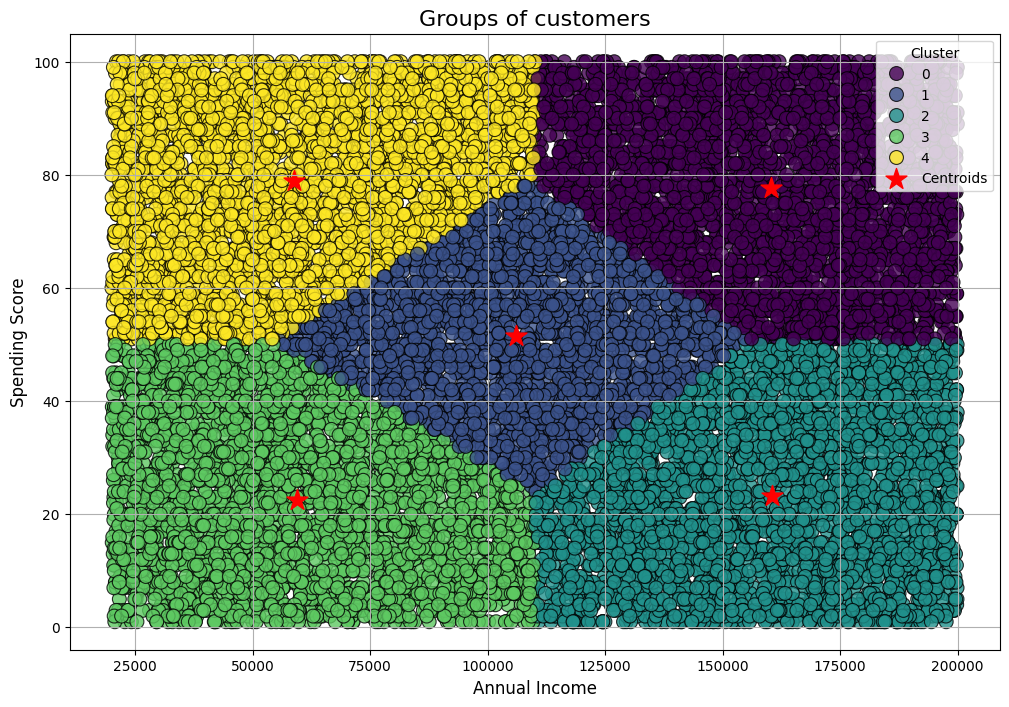

In [12]:
df['Cluster'] = clusters

plt.figure(figsize=(12, 8))
sns.scatterplot(x='Annual Income', y='Spending Score', hue='Cluster', data=df, palette='viridis', s=100, alpha=0.8, edgecolor='k')

centers = scaler.inverse_transform(kmeans.cluster_centers_)
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=250, marker='*', label='Centroids')

plt.title('Groups of customers', fontsize=16)
plt.xlabel('Annual Income', fontsize=12)
plt.ylabel('Spending Score', fontsize=12)
plt.legend(title='Cluster')
plt.grid(True)
plt.show()

In [13]:
print("center of clusters:")
cluster_centers_df = pd.DataFrame(centers, columns=['Annual Income', 'Spending Score'])
print(cluster_centers_df)

center of clusters:
   Annual Income  Spending Score
0  160267.343625       77.739117
1  106042.925658       51.498726
2  160477.354245       23.278714
3   59520.105559       22.517177
4   58873.085065       78.948377


Согласно рисункy:
- Кластер 0 (фиолетовый): высокий доход, высокие расходы
- Кластер 1 (тёмно-синий): средний доход, средние расходы
- Кластер 2 (светло-зелёный): низкий доход, низкие расходы
- Кластер 3 (сине-зелёный): низкий доход, высокие расходы
- Кластер 4 (жёлтый): высокий доход, низкие расходы

Иерархическая кластеризация

In [14]:
hc = AgglomerativeClustering(n_clusters=5, linkage='ward')
labels_hc = hc.fit_predict(X_scaled)
silhouette_hc = silhouette_score(X_scaled, labels_hc)
print(f"silhouette_hc: {silhouette_hc:.4f}")

silhouette_hc: 0.3308


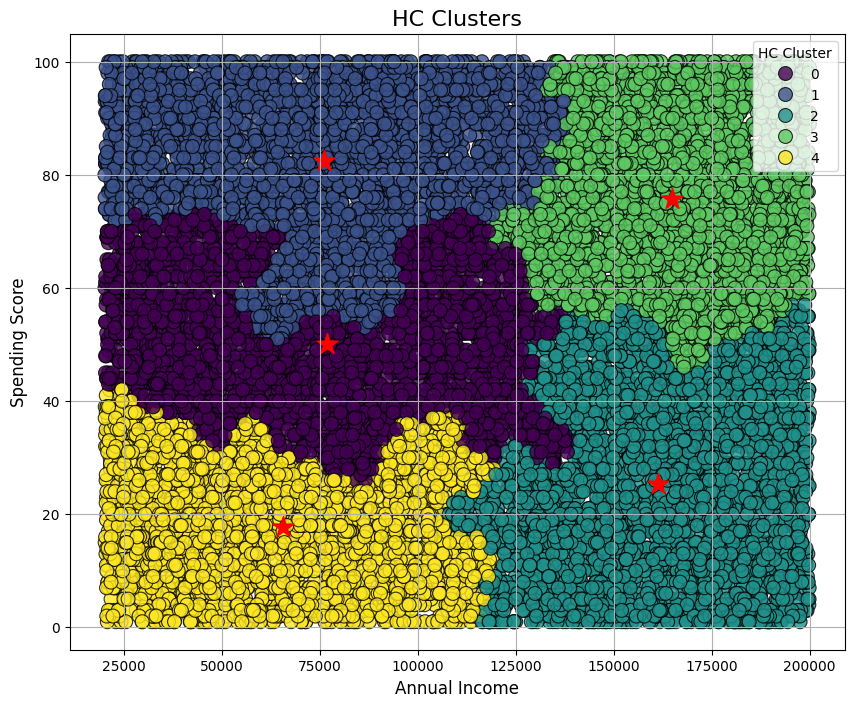

In [15]:
df['HC_Cluster'] = labels_hc
hc_centroids = df.groupby('HC_Cluster')[['Annual Income', 'Spending Score']].mean()
plt.figure(figsize=(10, 8))
sns.scatterplot(x='Annual Income', y='Spending Score', hue='HC_Cluster', data=df, palette='viridis', s=100, alpha=0.8, edgecolor='k')
plt.scatter(hc_centroids['Annual Income'], hc_centroids['Spending Score'], c='red', s=250, marker='*')
plt.title('HC Clusters', fontsize=16)
plt.xlabel('Annual Income', fontsize=12)
plt.ylabel('Spending Score', fontsize=12)
plt.legend(title='HC Cluster')
plt.grid(True)
plt.show()